In [1]:
# handle imports, init ncb
import torch
import torch.nn.functional as F
import json
import matplotlib.pyplot as plt
from matplotlib.image import imread
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor
from PIL import Image
import numpy as np
import pickle
import os
from neural_concept_binder import NeuralConceptBinder
import utils_ncb as utils_bnr
from torchvision import transforms
from argparse import Namespace
from datetime import datetime
import sglang as sgl
from sglang.srt.constrained import build_regex_from_object
from enum import Enum
from pydantic import BaseModel
import argparse
import cv2
from scipy.optimize import linear_sum_assignment

import sys

if "core" not in sys.path:
    sys.path.append("/app/RAFT/core")

from raft import RAFT
from utils.utils import InputPadder

# load optical flow model
raft_args = argparse.Namespace(
    model="/app/RAFT/models/raft-things.pth",
    # path="my_demo-frames",
    small=False,
    mixed_precision=False,
    alternate_corr=False,
)
raft_model = torch.nn.DataParallel(RAFT(raft_args))
raft_model.load_state_dict(torch.load(raft_args.model))
raft_model = raft_model.module
raft_model.to("cuda")
raft_model.eval()

# load Object Detection
sam2_checkpoint = "checkpoints/sam2.1_hiera_tiny.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_t.yaml"
sam2_model = build_sam2(model_cfg, sam2_checkpoint, device=torch.device("cuda"))
predictor = SAM2ImagePredictor(sam2_model)

# prepare ncb retrieval corpus
ncb_seed = 1
# with open(
#     f"/app/ncb/CLEVR-4/retbind_seed_{ncb_seed}/block_concept_dicts.pkl", "rb"
# ) as f:
with open(
    # f"/app/ncb/logs/clevrer_seed_{ncb_seed}/block_concept_dicts.pkl", "rb"
    f"/app/ncb/logs/car_parts_seed_{ncb_seed}/block_concept_dicts.pkl", "rb"
) as f:
    block_concepts = pickle.load(f)
with open(
    # f"/app/ncb/logs/clevrer_seed_{ncb_seed}/all_img_locs.pkl", "rb"
    f"/app/ncb/logs/car_parts_seed_{ncb_seed}/all_img_locs.pkl", "rb"
    ) as f:
    all_img_locs = pickle.load(f)

# setup ncb
utils_bnr.set_seed(0)
args = Namespace(
    seed=0,
    batch_size=20,
    num_workers=0,
    image_size=128,
    # image_height=128,
    # image_width=192,
    image_channels=3,
    data_path="data/*.png",
    perc_imgs=1.0,
    log_path="../logs/",
    # checkpoint_path=f"/app/ncb/logs/clevrer_seed_{ncb_seed}/best_model.pt",
    checkpoint_path=f"/app/ncb/logs/car_parts_seed_{ncb_seed}/best_model.pt",
    model_type="ncb",
    use_dp=False,
    name=datetime.now().strftime("%Y-%m-%d_%H:%M:%S"),
    num_categories=3,
    clf_type="dt",
    lr_dvae=0.0003,
    lr_enc=0.0001,
    lr_dec=0.0003,
    lr_warmup_steps=30000,
    lr_half_life=250000,
    clip=0.05,
    epochs=500,
    num_iterations=3,
    num_slots=4,
    num_blocks=16,
    cnn_hidden_size=512,
    slot_size=2048,
    mlp_hidden_size=192,
    num_prototypes=64,
    temp=1.0,
    temp_step=False,
    vocab_size=4096,
    num_decoder_layers=8,
    num_decoder_heads=4,
    d_model=192,
    dropout=0.1,
    tau_start=1.0,
    tau_final=0.1,
    tau_steps=30000,
    lr=0.01,
    binarize=False,
    attention_codes=False,
    # retrieval_corpus_path=f"/app/ncb/logs/clevrer_seed_{ncb_seed}/block_concept_dicts.pkl",
    retrieval_corpus_path=f"/app/ncb/logs/car_parts_seed_{ncb_seed}/block_concept_dicts.pkl",
    deletion_dict_path=None,
    merge_dict_path=None,
    retrieval_encs="proto-exem",
    majority_vote=False,
    topk=5,
    thresh_attn_obj_slots=0.98,
    thresh_count_obj_slots=-1,  # -1 for all
    device="cuda",
)
utils_bnr.set_seed(0)
if args.model_type == "ncb":
    ncb_model = NeuralConceptBinder(args)
else:
    raise ValueError(f"Model type {args.model_type} not handled in this script!")
ncb_model.to(args.device)
ncb_model.eval()
torch.set_grad_enabled(True)

# treshold for my smoothing etc
binary_metric_threshold = 3
continuous_frames_threshold = 3

Loading retrieval corpus from /app/ncb/logs/car_parts_seed_1/block_concept_dicts.pkl ...

Number of concepts per block: 
[1, 1, 2, 16, 1, 1, 7, 1, 1, 1, 1, 1, 11, 1, 3, 1]



AttributeError: 'Namespace' object has no attribute 'image_size'

In [ ]:
# launch vlm server in separate terminal via:
# python3 -m sglang.launch_server --model-path lmms-lab/llava-onevision-qwen2-7b-ov --port=30000 --chat-template=chatml-llava --host=0.0.0.0
# after starting server somewhere else
from sglang.utils import wait_for_server

# !ping sgl_server
# TODO: Use docker network
wait_for_server("http://sgl_server:30000")
sgl.set_default_backend(sgl.RuntimeEndpoint("http://sgl_server:30000"))

In [9]:
# dynamic programming table for storing already retrieved prototype information
prototype_table = {}

In [10]:
# define structured output
class color(str, Enum):
    brown = "brown"
    blue = "blue"
    yellow = "yellow"
    gray = "gray"
    green = "green"
    cyan = "cyan"
    red = "red"
    purple = "purple"


class shape(str, Enum):
    sphere = "sphere"
    cylinder = "cylinder"
    cube = "cube"


class material(str, Enum):
    rubber = "rubber"
    metal = "metal"


class size(str, Enum):
    small = "small"
    medium = "medium"
    large = "large"


class object_properties(BaseModel):
    color: color
    shape: shape
    material: material
    size: size

In [12]:
# methods for ncb, attribute retrieval, showing images
def get_block_by_id(slot, block_id, args):
    """
    Grab the specific block from a given slot.
    """
    # make sure slot is just 1D individual slot
    assert len(slot.shape) == 1
    block_size = args.slot_size // args.num_blocks

    block = slot[block_id * block_size : (block_id + 1) * block_size]

    return block


def transform_np_slots_to_torch_slots(np_slots):
    slots = torch.tensor(np_slots).to("cuda")
    return slots.unsqueeze(0)


def torch_img_to_np_img(torch_img):
    assert torch_img.shape[0] == 1
    img = torch_img[0].detach().cpu().numpy()
    return np.transpose(img, (1, 2, 0))


def describe_encoding_via_prototypes(codes: list[int]):
    prototype_table_entry = prototype_table.get(tuple(codes), None)
    if prototype_table_entry is not None:
        return (
            prototype_table_entry[0],
            prototype_table_entry[1],
        )  # return attribute dict, prototype image

    else:
        # get all prototypes of that encoding
        prototype = np.zeros(args.slot_size, dtype=np.float32)
        for block_id, cluster_id in enumerate(codes):
            # grab block from base slot
            tmp_block = get_block_by_id(prototype, block_id, args)
            # replace this block with the copy of the new block slot
            tmp_block[:] = np.copy(
                block_concepts[block_id]["prototypes"]["prototypes"][cluster_id]
            )

        prototype_image = torch_img_to_np_img(
            ncb_model.model.decode(
                transform_np_slots_to_torch_slots(prototype).unsqueeze(0)
            )
        )
        prototype_image = Image.fromarray(
            (prototype_image * 255).clip(0, 255).astype("uint8")
        )
        attribute_dict = object_description_gen(prototype_image)
        prototype_table[tuple(codes)] = (attribute_dict, prototype_image)
        return attribute_dict, prototype_image


def get_negative_point(masks: np.ndarray, neighbor_radius=5):
    mask = masks[0]
    height, width = mask.shape
    offset = 10

    for y in range(offset, height - offset):  # Avoid edges
        for x in range(offset, width - offset):
            # Extract the 5x5 neighborhood centered at (y, x)
            neighborhood = mask[
                y - neighbor_radius : y + neighbor_radius + 1,
                x - neighbor_radius : x + neighbor_radius + 1,
            ]

            # Check if all values in the neighborhood are False
            if np.all(neighborhood == False):
                return (
                    x,
                    y,
                )  # Return the first coordinate (x, y) that satisfies the condition

    raise RuntimeError(
        "Could not find a pixel with an entirely False neighborhood. Reduce neighbor_radius"
    )


def mean_center_of_mask(mask):
    # Get the coordinates of all non-zero pixels (foreground pixels)
    foreground_pixels = np.column_stack(np.where(mask == 1))

    if foreground_pixels.shape[0] == 0:
        return None  # Return None if there are no foreground pixels

    # Calculate the mean center (centroid) by averaging the coordinates
    mean_y = np.mean(foreground_pixels[:, 0])  # Mean of y-coordinates (rows)
    mean_x = np.mean(foreground_pixels[:, 1])  # Mean of x-coordinates (columns)

    return (mean_x, mean_y)  # Return the (x, y) coordinates of the centroid


def sum_weights_in_neighborhood(mask, neighborhood_size=10):
    rows, cols = mask.shape

    # Determine the center of the mask
    center_y, center_x = rows // 2, cols // 2

    # Calculate the boundaries of the neighborhood
    half_size = neighborhood_size // 2
    start_y = max(center_y - half_size, 0)
    end_y = min(center_y + half_size, rows)
    start_x = max(center_x - half_size, 0)
    end_x = min(center_x + half_size, cols)

    # Extract the neighborhood and calculate the sum of the weights
    neighborhood = mask[start_y:end_y, start_x:end_x]
    weight_sum = np.sum(neighborhood)

    return weight_sum


def reduce_attribute_dict(ad: dict) -> dict:
    reduced_dict = {}
    for key, value_list in ad.items():
        reference_value = value_list[0]
        varying_attribute = False
        for value in value_list:
            if value != reference_value:
                # TODO: introduce LLM back when ready. Don't really need it anymore, I think
                # if are_concepts_similar(key, reference_value, value):
                #     reference_value = get_common_name(key, reference_value, value)
                # else:
                varying_attribute = True
                break
        if not varying_attribute:
            reduced_dict[key] = reference_value

    return reduced_dict


def approximate_position(x, y, image_width=128, image_height=128):
    cell_width = image_width // 3
    cell_height = image_height // 3

    # Classify the x coordinate (left, center, right)
    if x < cell_width:
        horizontal_position = "left"
    elif x < 2 * cell_width:
        horizontal_position = "center"
    else:
        horizontal_position = "right"

    # Classify the y coordinate (top, center, bottom)
    if y < cell_height:
        vertical_position = "top"
    elif y < 2 * cell_height:
        vertical_position = "center"
    else:
        vertical_position = "bottom"

    # Return the bin position
    return horizontal_position, vertical_position


def get_position_attribute(image_filenames: list[str]):
    # get position attribute
    horizontal_position_list = []
    vertical_position_list = []
    for image_name in image_filenames:
        image = Image.open(image_name)
        image = np.array(image.convert("RGB"))
        H, W, C = image.shape
        predictor.set_image(image)

        # select background
        input_box = np.array([0, 0, H, W])
        background_masks, scores, logits = predictor.predict(
            point_coords=None,
            point_labels=None,
            box=input_box[None, :],
            multimask_output=False,
        )

        object_point = get_negative_point(background_masks)
        object_point = np.array([[object_point[0], object_point[1]]])
        object_label = np.array([1])

        object_masks, scores, logits = predictor.predict(
            point_coords=object_point, point_labels=object_label, multimask_output=False
        )
        mask_center = mean_center_of_mask(object_masks[0])
        horizintal_pos, vertical_pos = approximate_position(
            *mask_center, image_height=H, image_width=W
        )
        horizontal_position_list.append(horizintal_pos)
        vertical_position_list.append(vertical_pos)

    return horizontal_position_list, vertical_position_list


def get_example_filenames_from_block_cluster(
    block_id: int, cluster_id: int, num_examples: int = 10
):
    assert cluster_id <= len(
        block_concepts[block_id]["prototypes"]["ids"]
    ), "Cluster id exceeds number of clusters."
    num_examples = min(
        len(block_concepts[block_id]["exemplars"]["exemplar_ids"][cluster_id]),
        num_examples,
    )

    filepaths = []
    base_path = "/app/clevr_images/train/images/"

    for i in range(num_examples):
        id = block_concepts[block_id]["exemplars"]["exemplar_ids"][cluster_id][i]
        path = os.path.join(base_path, os.path.basename(all_img_locs[id]))
        filepaths.append(path)

    return filepaths


def get_ncb_encoding(img_fn: str, plot=False):
    # TODO: Why do I need to set a seed here for consistent results?
    utils_bnr.set_seed(0)

    img = Image.open(img_fn).convert("RGB")
    img.thumbnail((128, 128))
    transform = transforms.Compose(
        [
            transforms.CenterCrop((128, 128)),
            transforms.ToTensor(),
        ]
    )
    # transform = transforms.Compose(
    #     [
    #         transforms.Resize((128, 192)),
    #         transforms.ToTensor(),
    #     ]
    # )
    img_tensor = transform(img)
    img_tensor = img_tensor.unsqueeze(0)  # add batch dimension

    codes, probs, slots, attns_vis, attns = ncb_model.encode(img_tensor)

    if plot:
        for attention_mask, attention_vis in zip(
            attns.squeeze(0), attns_vis.squeeze(0)
        ):
            plot_attention_masks(img, img_tensor, attention_mask, attention_vis)
        print(codes.numpy().astype(int))

    return codes, probs, slots, attns_vis, attns


def show_images_from_filenames(image_filenames: list[str]):
    fig, axs = plt.subplots(1, len(image_filenames))
    for i in range(len(image_filenames)):
        axs[i].imshow(imread(image_filenames[i]))
        axs[i].axis("off")
    plt.show()
    plt.close()


def show_images_from_PIL(images: list[Image.Image], cmap=None):
    fig, axs = plt.subplots(1, len(images))
    for i in range(len(images)):
        axs[i].imshow(images[i], cmap=cmap)
        axs[i].axis("off")
    plt.show()
    plt.close()


def show_image_from_filename(image_filename: str):
    plt.imshow(imread(image_filename))
    plt.show()
    plt.close()


def show_image_from_PIL(image: Image.Image):
    plt.imshow(image)
    plt.show()
    plt.close()


@sgl.function
def object_description(s, image: str | Image.Image):
    s += sgl.user(
        sgl.image(image)
        + "Give me a description about the object in the image in the JSON format.\n"
    )
    s += sgl.gen(
        "object description",
        max_tokens=128,
        temperature=0.2,
        regex=build_regex_from_object(object_properties),  # Requires pydantic >= 2.0
    )


def object_description_gen(image: str | Image.Image):
    state = object_description.run(image)
    response = state.text()
    start_index = response.find("{")
    return json.loads(response[start_index:])


def show_exemplars(block_id: int, cluster_id: int, num_examples=10):
    image_filenames = get_example_filenames_from_block_cluster(
        block_id, cluster_id, num_examples=num_examples
    )
    show_images_from_filenames(image_filenames)


def plot_attention_masks(img, img_tensor, attns, attns_vis):
    # assume we only got one mask
    # my_attns = attns.cpu().detach().numpy().squeeze(0).squeeze(0).squeeze(0)
    my_attns = attns.cpu().detach().squeeze(0).numpy()
    print(sum_weights_in_neighborhood(my_attns, neighborhood_size=10))

    # my_vis = attns_vis.cpu().detach().numpy().squeeze(0).squeeze(0)
    my_vis = attns_vis.cpu().detach().numpy()
    my_vis = np.transpose(my_vis, (1, 2, 0))

    img_tensor = img_tensor.cpu().detach().numpy().squeeze(0)
    img_tensor = np.transpose(img_tensor, (1, 2, 0))

    _, axs = plt.subplots(1, 4, figsize=(12, 12))
    axs[0].imshow(img)
    axs[0].set_title("Downsized input image")
    axs[1].imshow(img_tensor)
    axs[1].set_title("Input image tensor")
    axs[2].imshow(my_attns, cmap="grey")
    axs[2].set_title("Attention weights")
    axs[3].imshow(my_vis)
    axs[3].set_title("Attention weights * input tensor")
    plt.show()
    plt.close()


def load_image_for_raft(imfile):
    img = np.array(Image.open(imfile)).astype(np.uint8)
    img = torch.from_numpy(img).permute(2, 0, 1).float()
    return img[None].to("cuda")


def simple_forward_warping(weights: np.ndarray, flow: np.ndarray):
    u = flow[:, :, 0]
    v = flow[:, :, 1]

    H, W = weights.shape
    warped_weights = np.zeros((H, W))
    for i in range(H):
        for j in range(W):
            new_x = i + int(np.rint(v[i, j]))
            new_y = j + int(np.rint(u[i, j]))
            if new_x in range(H) and new_y in range(W):
                warped_weights[new_x, new_y] += weights[i, j]

    return np.clip(warped_weights, None, 1)


def compute_soft_iou(mask1: np.ndarray, mask2: np.ndarray):
    return (
        np.sum(mask1 * mask2) / np.sum((mask1 + mask2) / 2)
        if np.sum(mask1 + mask2) > 0
        else 0
    )


# creates a mapping from which slot in the current image the slots in the next image are from
def get_slot_origins(masks1: np.ndarray, masks2: np.ndarray, flow: np.ndarray):
    warped_masks1 = [simple_forward_warping(m1, flow) for m1 in masks1]
    similarities = np.array(
        [[compute_soft_iou(wm1, m2) for m2 in masks2] for wm1 in warped_masks1]
    )
    row_indices, col_indices = linear_sum_assignment(
        -similarities
    )  # Use negative to maximize similarity
    return {col: row for row, col in zip(row_indices, col_indices)}


def resize_optical_flow(flow: np.ndarray, target_shape: tuple):
    """
    Resize optical flow to a smaller resolution.

    Parameters:
        flow (np.ndarray): Optical flow of shape (H, W, 2), where the last dimension
                           represents (flow_x, flow_y).
        target_shape (tuple): Target height and width as (H_target, W_target).

    Returns:
        np.ndarray: Resized optical flow of shape (H_target, W_target, 2).
    """
    h1, w1, _ = flow.shape
    h2, w2 = target_shape

    # Resize the flow field
    resized_flow = cv2.resize(flow, (w2, h2), interpolation=cv2.INTER_LINEAR)

    # Scale the flow values
    scale_x = w2 / w1
    scale_y = h2 / h1
    resized_flow[..., 0] *= scale_x  # Scale x-component of flow
    resized_flow[..., 1] *= scale_y  # Scale y-component of flow

    return resized_flow


# returns dict with structure [object_id][frame_id]
def track_objects_through_frames(
    frame_transitions: list[dict],
    encs: list[np.ndarray],
    attn_masks: np.ndarray,
    first_object_id=0,
):
    object_id = first_object_id
    object_dict = dict()
    previous_slot_to_object_id = dict()
    for index, enc in enumerate(encs[0]):
        object_dict[object_id] = {0: {"enc": enc, "mask": attn_masks[0][index]}}
        previous_slot_to_object_id[index] = index
        object_id += 1

    for i in range(len(frame_transitions)):
        current_slot_to_object_id = dict()
        for slot_id in range(len(encs[i + 1])):
            prev_slot_id = frame_transitions[i].get(slot_id, None)
            # create new dict for new object
            if prev_slot_id is None:
                object_dict[object_id] = dict()
                current_object_id = object_id
                object_id += 1

            # find existing object_id
            else:
                current_object_id = previous_slot_to_object_id[prev_slot_id]
                # for id in range(object_id):
                #     current_object_id = object_dict[id][i]["slot_index"]
                #     if current_object_id == prev_slot_id:
                #         break

            current_slot_to_object_id[slot_id] = current_object_id

            object_dict[current_object_id][i + 1] = {
                "enc": encs[i + 1][slot_id],
                "mask": attn_masks[i + 1][slot_id],
            }
        previous_slot_to_object_id = current_slot_to_object_id

    return object_dict


def plot_image_with_object_masks(image, grayscale_images, object_ids):
    """
    Plots the given image and an array of grayscale images side by side in subplots.
    Each grayscale image is displayed with a unique color.

    Parameters:
        image (ndarray): The main image to display (assumed to be in RGB or grayscale format).
        grayscale_images (list of ndarray): A list of 2D numpy arrays representing grayscale images.
    """
    # Define a list of colors to map to the grayscale images
    colors = ["Reds", "Blues", "Greens", "Purples"]

    # Ensure there are enough colors for all grayscale images
    if len(grayscale_images) > len(colors):
        raise ValueError(
            "Too many grayscale images; please provide fewer images or expand the color palette."
        )

    # Set up the subplot grid
    total_images = 1 + len(
        grayscale_images
    )  # 1 for the main image + all grayscale images
    fig, axes = plt.subplots(1, total_images, figsize=(2 * total_images, 2))

    # Plot the main image in the first subplot
    axes[0].imshow(image)
    axes[0].set_title("Original Image")
    axes[0].axis("off")

    # Plot each grayscale image with a unique color
    for idx, (grayscale_img, color) in enumerate(
        zip(grayscale_images, colors), start=1
    ):
        axes[idx].imshow(grayscale_img, aspect="auto", cmap=color)
        axes[idx].set_title(f"Slot mask for object {object_ids[idx-1]}")
        axes[idx].axis("off")

    plt.tight_layout()
    plt.show()


def get_masks_for_frame_id(object_dict: dict, frame_id: int):
    object_masks = list()
    object_ids = list()
    for key in object_dict.keys():
        frame_dict = object_dict[key].get(frame_id, None)
        if frame_dict is not None:
            object_masks.append(frame_dict["mask"])
            object_ids.append(key)

    return object_masks, object_ids


# useful for recognizing that different objects are actually the same
def binary_similarity_thresholding(enc1, enc2):
    """
    Returns True if there are not more than `binary_metric_threshold` many differences in the encoding pairs
    """
    energy = np.sum([0 if enc1[i] == enc2[i] else 1 for i in range(len(enc1))])
    return energy <= binary_metric_threshold


def has_consecutive_numbers(arr, threshold):
    arr = sorted(arr)
    if len(arr) < threshold:
        return False  # Not enough elements to have three consecutive numbers

    count = 1  # Count for consecutive numbers
    for i in range(1, len(arr)):
        if (
            arr[i] == arr[i - 1] + 1
        ):  # Check if the current number continues the sequence
            count += 1
            if count >= 3:  # If we have found three or more consecutive numbers
                return True
        else:
            count = 1  # Reset the count if the sequence is broken

    return False  # No sequence of three consecutive numbers found


def filter_noncontinuous_artifacts(object_dict: dict[dict]):
    filtered_dict = dict()
    for key in object_dict.keys():
        frame_ids = object_dict[key].keys()
        if has_consecutive_numbers(frame_ids, continuous_frames_threshold):
            filtered_dict[key] = object_dict[key]

    return filtered_dict


# TODO: What if two matches are in the same frame?
def find_and_fuse_similar_objects(object_dict: dict, object_id: int):
    try:
        current_object = object_dict[object_id]
    except KeyError:
        return object_dict
    
    all_objects_ids = set(object_dict.keys())
    object_ids_in_frame_of_current_object = set()

    # get all objects that are together in a frame as current_object
    for frame_id in current_object.keys():
        for obj_id in all_objects_ids:
            if frame_id in object_dict[obj_id].keys():
                object_ids_in_frame_of_current_object.add(obj_id)

    object_candidates_id = all_objects_ids.difference(
        object_ids_in_frame_of_current_object
    )
    match_ids = set([object_id])
    for candidate_id in object_candidates_id:
        candidate = object_dict[candidate_id]
        if np.max(current_object.keys()) > np.max(candidate.keys()):
            cur_frame = np.min(list(current_object.keys()))
            can_frame = np.max(list(candidate.keys()))
        else:
            cur_frame = np.max(list(current_object.keys()))
            can_frame = np.min(list(candidate.keys()))

        if binary_similarity_thresholding(
            current_object[cur_frame]["enc"], candidate[can_frame]["enc"]
        ):
            match_ids.add(candidate_id)

    if len(match_ids) == 1:
        return object_dict

    combined_dict = dict()
    combined_dict.update(
        {key: object_dict[key] for key in all_objects_ids.difference(match_ids)}
    )
    combined_dict[object_id] = {
        frame: object_dict[match][frame]
        for match in match_ids
        for frame in object_dict[match].keys()
    }

    return combined_dict

In [2]:
# define base paths for video frames
blackened_base_path = "/app/ncb/edited_videos/video_10000/cropped_images"
unedited_base_path = "/app/ncb/edited_videos/video_10003/video_frames"

# square_base_path = "/app/ncb/square_imgs/video_10001"
square_base_path = "/app/ncb/square_video_frames/video_10003"
# square_base_path = "/app/ncb/square_imgs/test_images"

# get image filenames
base_path = square_base_path
frame_names = sorted(os.listdir(base_path))[:30:10]
frame_names = [os.path.join(base_path, frame_name) for frame_name in frame_names]
print(frame_names)

ncb_encodings, _, _, _, attention_masks = zip(*[get_ncb_encoding(fn, plot=True) for fn in frame_names])
# best_indices = [np.argmax([sum_weights_in_neighborhood(mask, neighborhood_size=10) for mask in atn.squeeze((0, 2)).cpu().detach().numpy()]) for atn in attention_masks]
# ncb_encodings = np.array([enc.squeeze(0)[best_indices[i]] for i, enc in enumerate(ncb_encodings)]).astype(int)

['/app/ncb/square_video_frames/video_10003/00000.jpg', '/app/ncb/square_video_frames/video_10003/00010.jpg', '/app/ncb/square_video_frames/video_10003/00020.jpg']


NameError: name 'get_ncb_encoding' is not defined

In [16]:
torch.sum(attention_masks[0].squeeze() == 0.25) / np.prod(np.array(attention_masks[0].shape))

tensor(1., device='cuda:0')

In [133]:
ncb_encs = [enc.squeeze(0).cpu().numpy().astype(int) for enc in ncb_encodings]
masks = [attn.squeeze((0, 2)).cpu().detach().numpy() for attn in attention_masks]
flows = []
with torch.no_grad():
    for imfile1, imfile2 in zip(frame_names[:-1], frame_names[1:]):
        image1 = load_image_for_raft(imfile1)
        image2 = load_image_for_raft(imfile2)

        padder = InputPadder(image1.shape)
        image1, image2 = padder.pad(image1, image2)

        flow_low, flow_up = raft_model(image1, image2, iters=20, test_mode=True)
        flows.append(flow_up)

flows = [resize_optical_flow(flo.squeeze().permute(1, 2, 0).cpu().numpy(), masks[0].shape[1:]) for flo in flows]

slot_mappings = [get_slot_origins(masks[i], masks[i+1], flows[i]) for i in range(len(masks)-1)]

# TODO: do cool thnigs with the object time series now. Probably filter it
object_dict = track_objects_through_frames(slot_mappings, ncb_encs, masks, first_object_id=0)
print(slot_mappings)
print(object_dict)

[{0: 0, 1: 1}, {0: 0, 1: 1}, {0: 0, 1: 1}, {0: 0, 1: 1}, {1: 0, 2: 1}, {0: 0, 1: 1, 2: 2}, {0: 0, 1: 1, 2: 2}, {0: 1, 1: 2}, {0: 0, 1: 1}]
{0: {0: {'enc': array([ 28,   0,   2,   1,   3,   0,   3,   7,   5,  11,   2, 144,   2,
         1,   0,  24]), 'mask': array([[0.16479886, 0.16479886, 0.11648708, ..., 0.23878217, 0.18105572,
        0.18105572],
       [0.16479886, 0.16479886, 0.11648708, ..., 0.23878217, 0.18105572,
        0.18105572],
       [0.19297232, 0.19297232, 0.13170262, ..., 0.16425031, 0.11907061,
        0.11907061],
       ...,
       [0.42876107, 0.42876107, 0.39105782, ..., 0.19801435, 0.20293772,
        0.20293772],
       [0.41841805, 0.41841805, 0.44300398, ..., 0.24936046, 0.26313192,
        0.26313192],
       [0.41841805, 0.41841805, 0.44300398, ..., 0.24936046, 0.26313192,
        0.26313192]], dtype=float32)}, 1: {'enc': array([ 28,   0,   2,   1,   3,   0,   3,   7,   5,  11,   2, 144,   2,
         1,   0,  24]), 'mask': array([[0.16388576, 0.16388576, 

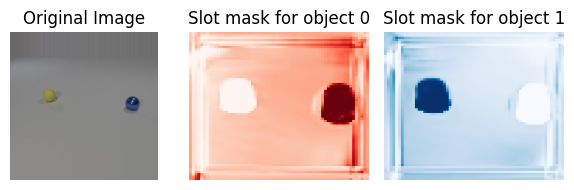

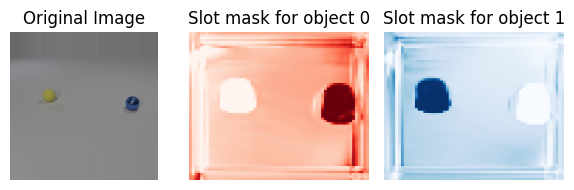

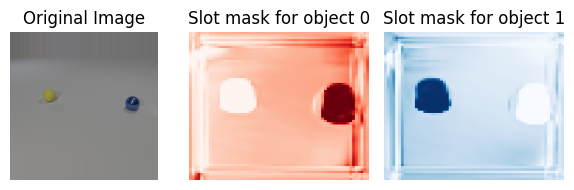

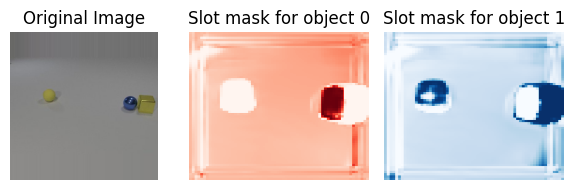

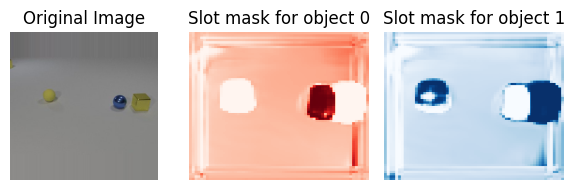

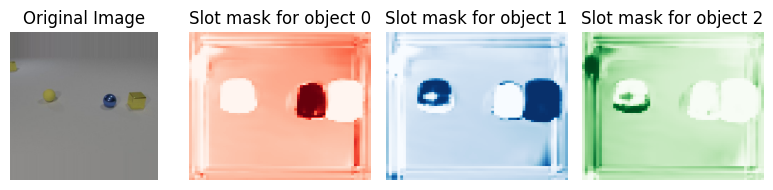

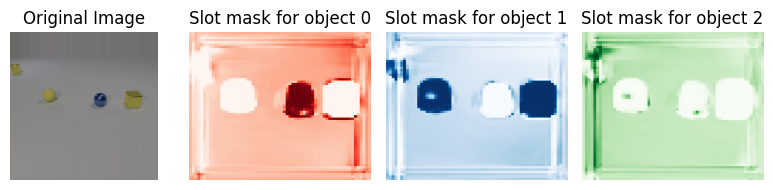

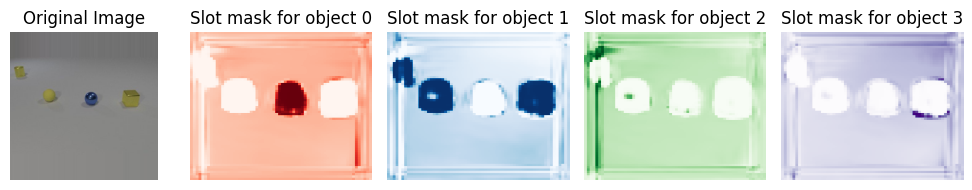

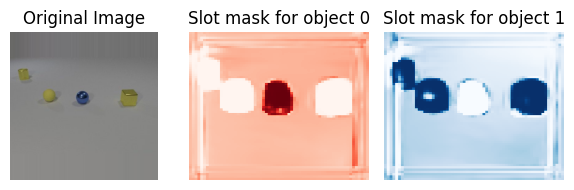

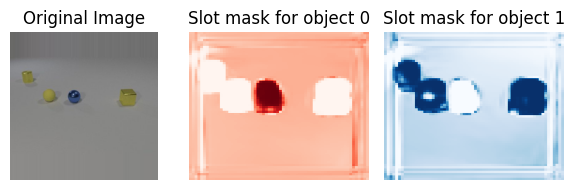

In [134]:
# original time series
for frame_number in range(len(frame_names)):
    masks, ids = get_masks_for_frame_id(object_dict, frame_number)
    plot_image_with_object_masks(Image.open(frame_names[frame_number]), masks, ids)

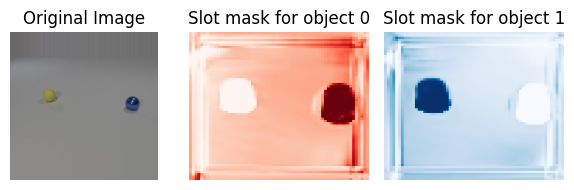

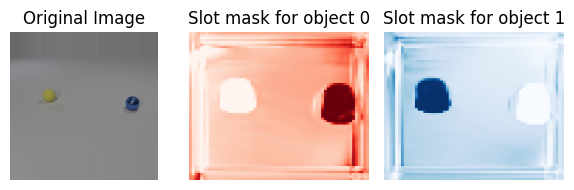

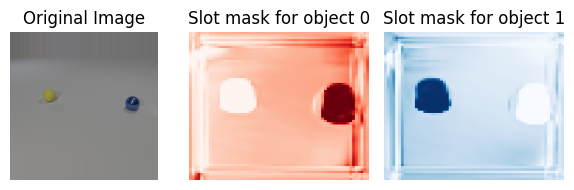

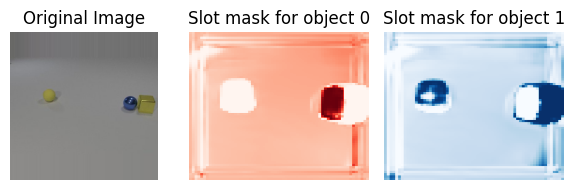

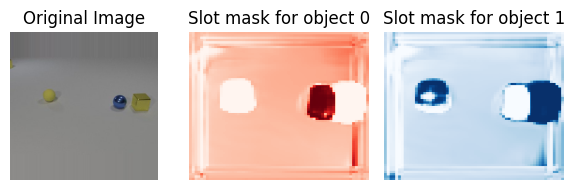

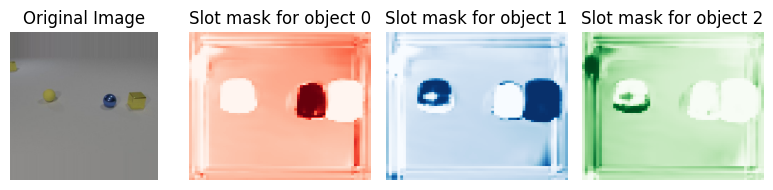

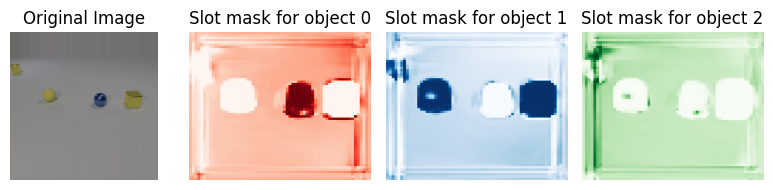

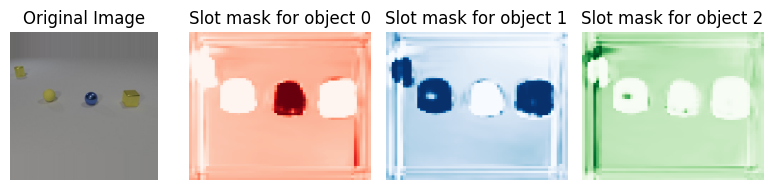

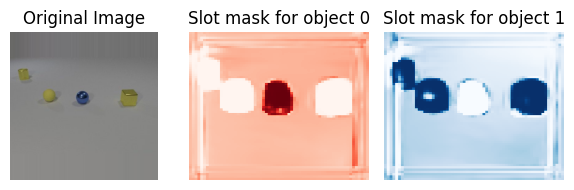

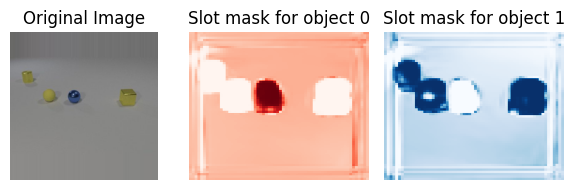

In [135]:
# filter objects which don't appear at least in three consecutive frames
filtered_object_dict = filter_noncontinuous_artifacts(object_dict)
for frame_number in range(len(frame_names)):
    masks, ids = get_masks_for_frame_id(filtered_object_dict, frame_number)
    plot_image_with_object_masks(Image.open(frame_names[frame_number]), masks, ids)

dict_keys([0, 1, 2, 3])


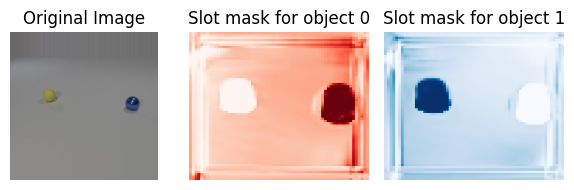

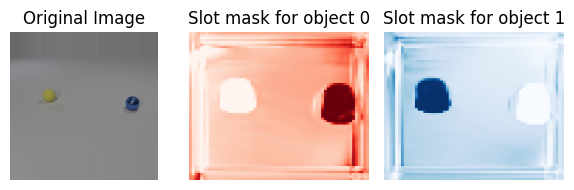

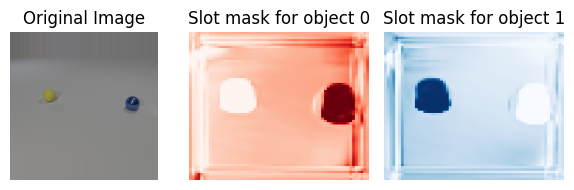

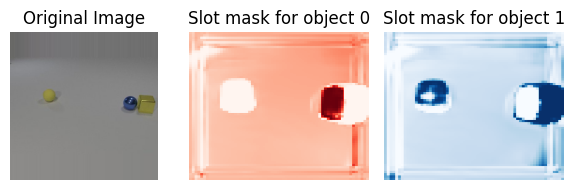

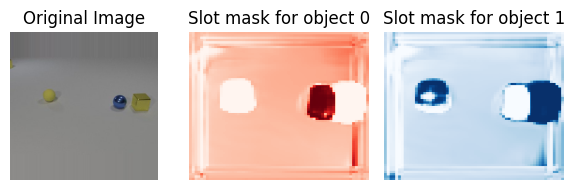

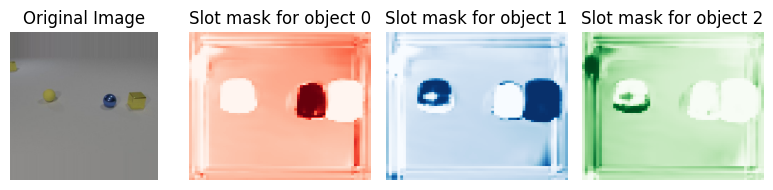

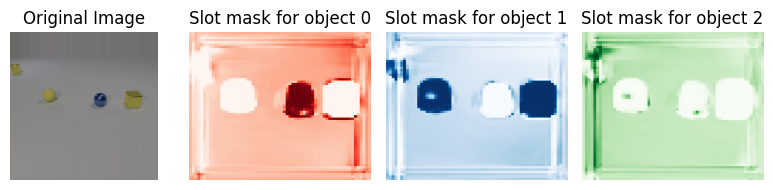

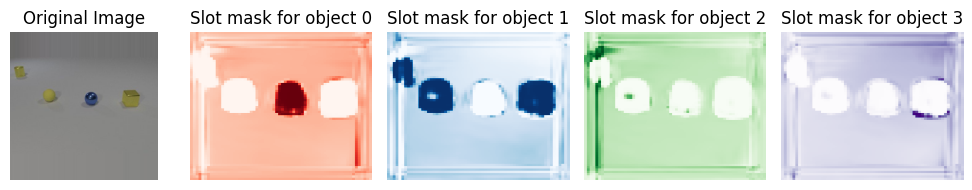

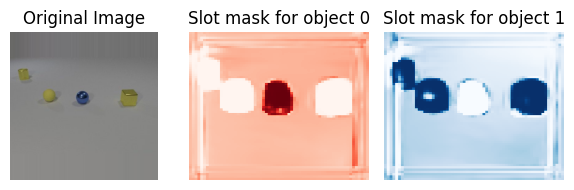

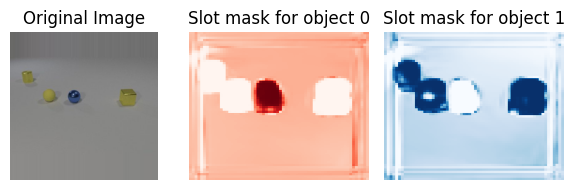

In [136]:
# fuse objects together if they are similar regarding to a binary metric
fused_dict = object_dict
for id in object_dict.keys():
    fused_dict = find_and_fuse_similar_objects(fused_dict, id)

print(fused_dict.keys())

for frame_number in range(len(frame_names)):
    masks, ids = get_masks_for_frame_id(fused_dict, frame_number)
    plot_image_with_object_masks(Image.open(frame_names[frame_number]), masks, ids)

In [ ]:
# visualize exemplars for each block of an encoding vector
encoding_to_look_at = ncb_encodings[0]

for i in range(len(encoding_to_look_at)):
    show_exemplars(i, encoding_to_look_at[i], num_examples=5)

In [143]:
# Get attributes from temporal obejct dict
object_id = 0
object_codes = [object_dict[object_id][frame_id]["enc"] for frame_id in object_dict[object_id].keys()]
object_masks = [object_dict[object_id][frame_id]["mask"] for frame_id in object_dict[object_id].keys()]
attribute_dicts, prototype_images = zip(*[describe_encoding_via_prototypes(codes) for codes in object_codes])

# use VLM to get attributes from decoded NCB prototypes (takes around 9 minutes for a whole video on a 4090 or takes 0 seconds if results are already cached in prototype_table)
# old version without temporal dict
# attribute_dicts, prototype_images = zip(*[describe_encoding_via_prototypes(codes) for codes in ncb_encodings])

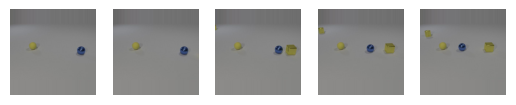

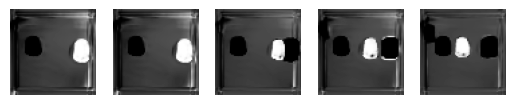

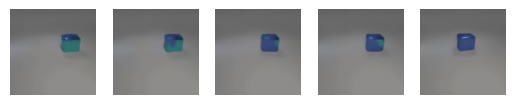

In [146]:
visualization_index = slice(0, 10, 2)

# plot images and their ncb encodings
show_images_from_filenames(frame_names[visualization_index])
# print(ncb_encodings[visualization_index])

# plot the according masks
show_images_from_PIL(object_masks[visualization_index], cmap="grey")

# show prototype images
show_images_from_PIL(prototype_images[visualization_index])

Original image:


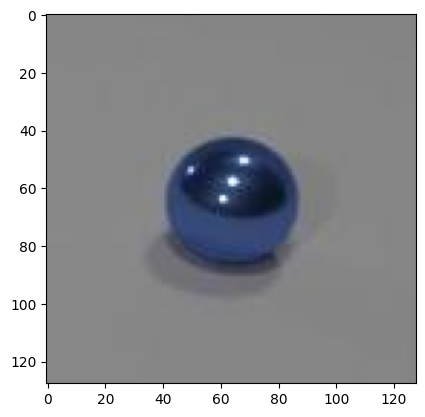

Prototype image:


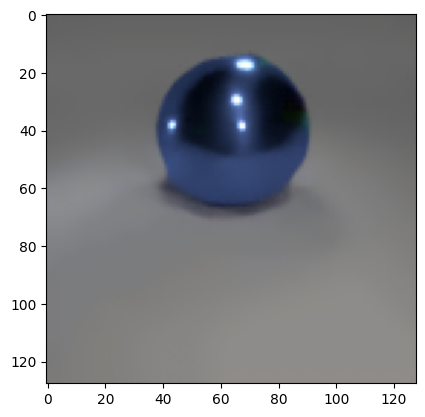

{'color': 'blue', 'shape': 'sphere', 'material': 'metal', 'size': 'small'}


In [35]:
# showcase of prototype reconstruction for attribute retrieval
frame_index = 0
attributes, prototype_image = describe_encoding_via_prototypes(ncb_encodings[frame_index])

# plot original image
print("Original image:")
show_image_from_filename(frame_names[frame_index])

# plot prototype image
print("Prototype image:")
show_image_from_PIL(prototype_image)

# attributes retrieved from prototype
print(attributes)

In [128]:
# Press attribute dicts into the same form as gt
def format_dicts(attributes: list[dict], format_keys: list[str]) -> list[dict]:
    formatted_list = []
    for att in attributes:
        formatted_dict = dict()
        for key in format_keys:
            formatted_dict[key] = att.get(key, None)
        formatted_list.append(formatted_dict)

    return formatted_list

In [145]:
# format dict for prototype attribute dicts
formatted_dicts = format_dicts(attribute_dicts, ["color", "material", "shape"])
print("formatted dicts:")
for fd in formatted_dicts:
    print(fd)

formatted dicts:
{'color': 'cyan', 'material': 'rubber', 'shape': 'cube'}
{'color': 'cyan', 'material': 'rubber', 'shape': 'cube'}
{'color': 'blue', 'material': 'rubber', 'shape': 'cube'}
{'color': 'blue', 'material': 'metal', 'shape': 'cube'}
{'color': 'blue', 'material': 'rubber', 'shape': 'cube'}
{'color': 'blue', 'material': 'metal', 'shape': 'cube'}
{'color': 'blue', 'material': 'rubber', 'shape': 'cube'}
{'color': 'blue', 'material': 'metal', 'shape': 'cube'}
{'color': 'blue', 'material': 'metal', 'shape': 'cube'}
{'color': 'blue', 'material': 'metal', 'shape': 'cube'}


In [11]:
# methods for assessing resulting attributes dicts
# assume you got two dicts with the same structure, check how many entries are the same
def compare_attribute_dicts(dict1: dict, dict2: dict):
    return np.mean([dict1[key] == dict2[key] for key in dict1])


def dict_accuracy_over_video(attribute_dicts: list[dict], gt: dict):
    return np.mean([compare_attribute_dicts(gt, ad) for ad in attribute_dicts])


def convert_dicts_to_boolean_array(attribute_dicts: list[dict], gt: dict):
    return np.array([[ad[key] == gt[key] for ad in attribute_dicts] for key in gt])


def plot_attribute_correctness(formatted_dicts: list[dict], gt: dict):
    print(f"ground truth: {gt}")

    n, m = len(formatted_dicts), len(gt.keys())
    time = np.arange(n)
    fig, ax = plt.subplots(figsize=(10, 6))

    for t in time:
        y = 0
        for key in gt.keys():
            color = "green" if formatted_dicts[t][key] == gt[key] else "red"
            ax.barh(y, 1, left=t-0.5, color=color, edgecolor="black", height=0.75)
            y += 1

    # Formatting
    ax.set_yticks(range(m))
    ax.set_yticklabels([f"{key}" for key in gt.keys()])
    ax.set_xlabel("frame")
    ax.set_title("Correctness of retrieved attributes over time")
    ax.invert_yaxis()  # Optional: invert y-axis for better readability

    plt.tight_layout()
    plt.show()

Overall attribute accuracy: 0.671875
ground truth: {'color': 'purple', 'material': 'metal', 'shape': 'cylinder'}


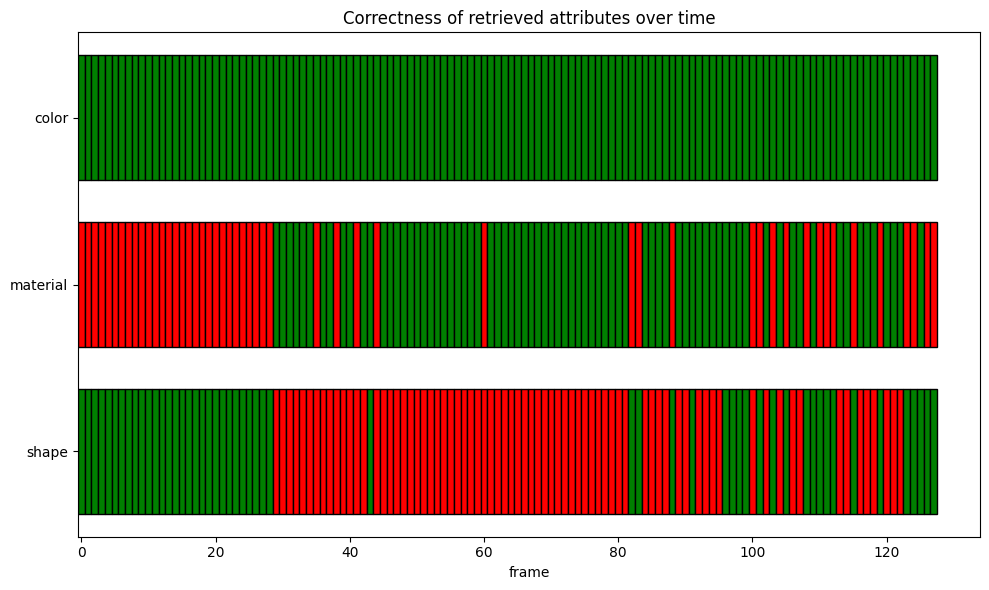

In [ ]:
# plot correctness of attributes
gt = {"color": "blue", "material": "metal", "shape": "sphere"}
print(f"Overall attribute accuracy: {dict_accuracy_over_video(formatted_dicts, gt)}")
plot_attribute_correctness(formatted_dicts, gt)

In [13]:
# create truth arrays from retrieved attributes and gt
truth_array = convert_dicts_to_boolean_array(formatted_dicts, gt)
key_index_dict = dict(zip(gt.keys(), range(len(gt.keys()))))

# compute accuracy and variance
accuracy_per_attribute = np.mean(truth_array, axis=1)
variance_per_attribute = np.var(truth_array, axis=1)

print(accuracy_per_attribute)
print(variance_per_attribute)
# print(accuracy_per_attribute[key_index_dict["color"]])
# print(variance_per_attribute[key_index_dict["color"]])

[1.        0.6015625 0.4140625]
[0.         0.23968506 0.24261475]
